In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the BTC Daily and Hourly datasets
btc_daily_path = Path("Resources/BTC-Daily.csv")
btc_hourly_path = Path("Resources/BTC-Hourly.csv")

# Read the datasets
btc_daily = pd.read_csv(btc_daily_path)
btc_hourly = pd.read_csv(btc_hourly_path)

# Display first few rows of both datasets
btc_daily.head(), btc_hourly.head()

(         unix                 date   symbol      open      high       low  \
 0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
 1  1646006400  2022-02-28 00:00:00  BTC/USD  37717.10  44256.08  37468.99   
 2  1645920000  2022-02-27 00:00:00  BTC/USD  39146.66  39886.92  37015.74   
 3  1645833600  2022-02-26 00:00:00  BTC/USD  39242.64  40330.99  38600.00   
 4  1645747200  2022-02-25 00:00:00  BTC/USD  38360.93  39727.97  38027.61   
 
       close   Volume BTC    Volume USD  
 0  43185.48    49.006289  2.116360e+06  
 1  43178.98  3160.618070  1.364723e+08  
 2  37712.68  1701.817043  6.418008e+07  
 3  39146.66   912.724087  3.573010e+07  
 4  39231.64  2202.851827  8.642149e+07  ,
          unix                 date   symbol      open      high       low  \
 0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
 1  1646089200  2022-02-28 23:00:00  BTC/USD  43085.30  43364.81  42892.37   
 2  1646085600  2022-02-28 22:00:00  BTC/US

In [38]:
# Convert 'date' column to datetime
btc_daily['date'] = pd.to_datetime(btc_daily['date'])
btc_hourly['date'] = pd.to_datetime(btc_hourly['date'])

# Aggregate hourly data to daily (mean values for prices and sum for volumes)
btc_hourly_agg = btc_hourly.groupby(btc_hourly['date'].dt.date).agg({
    'open': 'mean',
    'high': 'mean',
    'low': 'mean',
    'close': 'mean',
    'Volume BTC': 'sum',
    'Volume USD': 'sum'
}).reset_index()

# Convert 'date' back to datetime
btc_hourly_agg['date'] = pd.to_datetime(btc_hourly_agg['date'])

# Merge datasets on 'date'
btc_merged = pd.merge(btc_daily, btc_hourly_agg, on='date', suffixes=('_daily', '_hourly'))

# Sort by date
btc_merged = btc_merged.sort_values(by='date')

# Display the merged dataset using standard output
btc_merged.head()

,unix,date,symbol,open_daily,high_daily,low_daily,close_daily,Volume BTC_daily,Volume USD_daily,open_hourly,high_hourly,low_hourly,close_hourly,Volume BTC_hourly,Volume USD_hourly
1386,1526342400,2018-05-15,BTC/USD,8674.53,8865.00,8400.00,8474.99,12391.831987,1.050207e+08,8632.892222,8674.121667,8570.976111,8618.510556,8.915679e+07,10337.86
1385,1526428800,2018-05-16,BTC/USD,8481.99,8505.33,8100.01,8346.59,12705.123220,1.060445e+08,8279.441667,8340.754583,8232.085833,8274.091667,1.050582e+08,12705.10
1384,1526515200,2018-05-17,BTC/USD,8337.77,8500.00,7980.00,8067.03,8259.124524,6.662661e+07,8282.046250,8316.032917,8230.524167,8270.397917,6.821090e+07,8259.12
1383,1526601600,2018-05-18,BTC/USD,8058.16,8275.10,7929.53,8248.87,7181.203883,5.923682e+07,8098.805417,8144.327500,8065.463750,8106.382083,5.809350e+07,7181.20
1382,1526688000,2018-05-19,BTC/USD,8248.99,8395.00,8141.08,8231.20,3784.075766,3.114748e+07,8256.557500,8286.535833,8225.112083,8255.821250,3.124393e+07,3784.09


In [39]:
# Import necessary library for Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Display results
mae_train, rmse_train, mae_test, rmse_test

(97.44808470588237, 218.13885035952396, 1030.0412602888046, 1379.985654793356)

In [40]:
# Selecting relevant features for modeling
btc_model_data = btc_merged[['date', 'close_daily', 'close_hourly', 'Volume BTC_daily', 'Volume BTC_hourly', 'Volume USD_daily', 'Volume USD_hourly']]

# Convert 'date' to index
btc_model_data.set_index('date', inplace=True)

# Function to create lag features
def create_lag_features(data, lags=5):
    df_lagged = data.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = data['close_daily'].shift(lag)
    df_lagged.dropna(inplace=True)  # Drop NaN values introduced by shifting
    return df_lagged

# Define number of lags
num_lags = 5

# Create lag features
btc_lagged = create_lag_features(btc_model_data, lags=num_lags)

# Split into train (80%) and test (20%)
train_size = int(len(btc_lagged) * 0.8)
train_lagged = btc_lagged[:train_size]
test_lagged = btc_lagged[train_size:]

# Features (X) and Target (y)
X_train, y_train = train_lagged.drop(columns=['close_daily']), train_lagged['close_daily']
X_test, y_test = test_lagged.drop(columns=['close_daily']), test_lagged['close_daily']

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Display results
mae_train, rmse_train, mae_test, rmse_test

(97.44808470588237, 218.13885035952396, 1030.0412602888046, 1379.985654793356)

In [41]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1
)

# Fit the model with training data
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_

# Train the best model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred_train_best = best_rf_model.predict(X_train)
y_pred_test_best = best_rf_model.predict(X_test)

# Evaluate performance
mae_train_best = mean_absolute_error(y_train, y_pred_train_best)
mae_test_best = mean_absolute_error(y_test, y_pred_test_best)

rmse_train_best = np.sqrt(mean_squared_error(y_train, y_pred_train_best))
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_pred_test_best))

# Display best parameters and results
best_params, mae_train_best, rmse_train_best, mae_test_best, rmse_test_best

({'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_depth': 10},
 128.49164520488438,
 292.0566168836451,
 1021.4300257371749,
 1372.9097711619324)

In [42]:
# Select features for modeling.
btc_model_data = btc_merged[['date', 'close_daily', 'close_hourly', 
                             'Volume BTC_daily', 'Volume BTC_hourly', 
                             'Volume USD_daily', 'Volume USD_hourly']]

# Set 'date' as index.
btc_model_data.set_index('date', inplace=True)

# Define a function to create lag features based on 'close_daily'
def create_lag_features(data, lags=5):
    df_lagged = data.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = data['close_daily'].shift(lag)
    df_lagged.dropna(inplace=True)  # Remove rows with NaN introduced by shifting
    return df_lagged

# Create lag features (using 5 lags in this example)
num_lags = 5
btc_lagged = create_lag_features(btc_model_data, lags=num_lags)
print("Data with Lag Features:")
print(btc_lagged.head())

Data with Lag Features:
            close_daily  close_hourly  Volume BTC_daily  Volume BTC_hourly  \
date                                                                         
2018-05-20      8518.48   8364.383750       5314.998900       4.450950e+07   
2018-05-21      8391.76   8452.892917       6126.971053       5.178041e+07   
2018-05-22      7984.08   8220.800833       9101.060787       7.453230e+07   
2018-05-23      7502.89   7777.621250      17635.901293       1.361499e+08   
2018-05-24      7586.88   7545.838750      11648.365244       8.748661e+07   

            Volume USD_daily  Volume USD_hourly    lag_1    lag_2    lag_3  \
date                                                                         
2018-05-20      4.527571e+07            5315.03  8231.20  8248.87  8067.03   
2018-05-21      5.141607e+07            6126.99  8518.48  8231.20  8248.87   
2018-05-22      7.266360e+07            9101.05  8391.76  8518.48  8231.20   
2018-05-23      1.323202e+08           

In [43]:
# Use 80% of the data for training and the remaining 20% for testing.
train_size = int(len(btc_lagged) * 0.8)
train_lagged = btc_lagged.iloc[:train_size]
test_lagged = btc_lagged.iloc[train_size:]

# Separate features (X) and target (y). Here, our target is 'close_daily'.
X_train = train_lagged.drop(columns=['close_daily'])
y_train = train_lagged['close_daily']
X_test = test_lagged.drop(columns=['close_daily'])
y_test = test_lagged['close_daily']

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [44]:
# Make predictions for both training and testing sets.
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [45]:
#Run
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Train MAE:", mae_train)
print("Train RMSE:", rmse_train)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)

Train MAE: 97.44808470588237
Train RMSE: 218.13885035952396
Test MAE: 1030.0412602888046
Test RMSE: 1379.985654793356


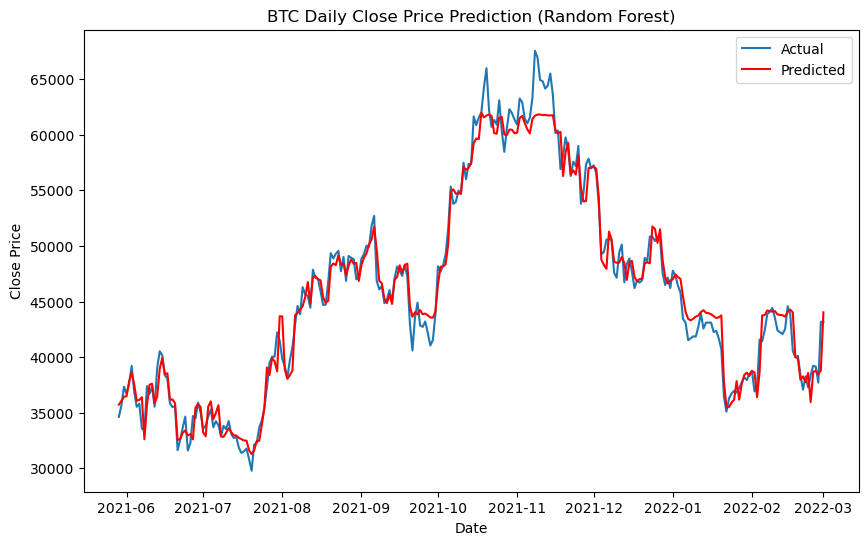

In [46]:
# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_test, label='Predicted', color='red')
plt.title('BTC Daily Close Price Prediction (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pathlib import Path

# Load BTC-Daily.csv (assuming the date column is named 'Date')
btc_daily_path = Path("Resources/BTC-Daily.csv")
btc_daily = pd.read_csv(btc_daily_path, parse_dates=['date'])
btc_daily.set_index('date', inplace=True)
btc_daily.sort_index(inplace=True)

# Display the first few rows
print("Daily Data Head:")
print(btc_daily.head())

Daily Data Head:
                  unix   symbol    open    high     low   close  Volume BTC  \
date                                                                          
2014-11-28  1417132800  BTC/USD  363.59  381.34  360.57  376.28  3220878.18   
2014-11-29  1417219200  BTC/USD  376.42  386.60  372.25  376.72  2746157.05   
2014-11-30  1417305600  BTC/USD  376.57  381.99  373.32  373.34  1145566.61   
2014-12-01  1417392000  BTC/USD  376.40  382.31  373.03  378.39  2520662.37   
2014-12-02  1417478400  BTC/USD  378.39  382.86  375.23  379.25  2593576.46   

            Volume USD  
date                    
2014-11-28     8617.15  
2014-11-29     7245.19  
2014-11-30     3046.33  
2014-12-01     6660.56  
2014-12-02     6832.53  


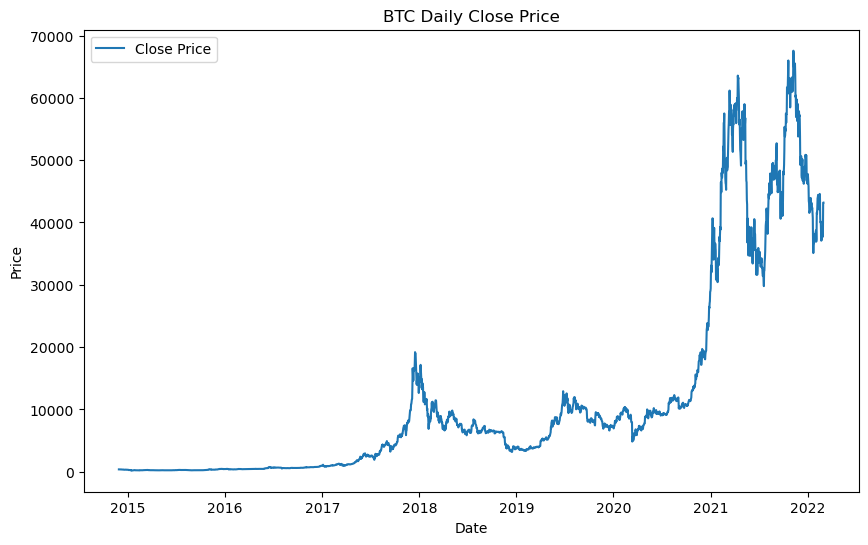

In [48]:
# Plot the daily close price
plt.figure(figsize=(10,6))
plt.plot(btc_daily.index, btc_daily['close'], label='Close Price')
plt.title('BTC Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


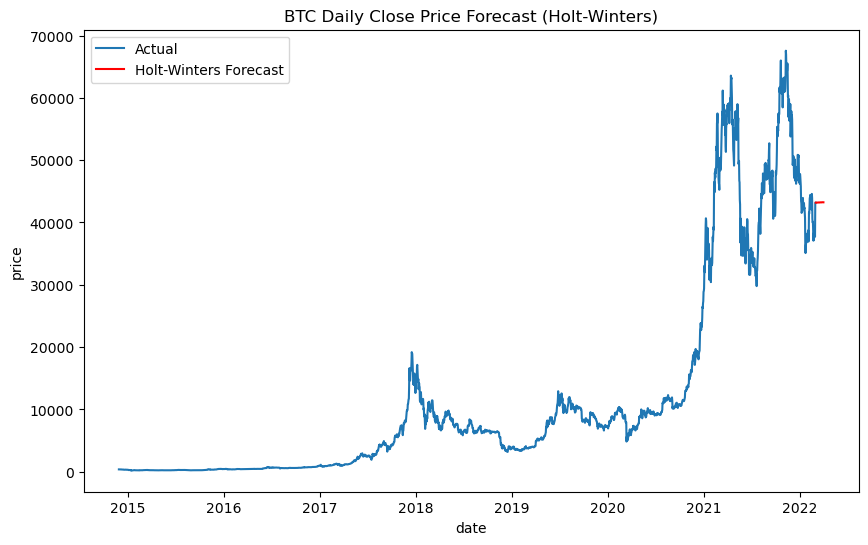

In [49]:
# Fit the Holt-Winters model with additive trend and seasonality (seasonal period of 7 for weekly seasonality)
hw_model = ExponentialSmoothing(btc_daily['close'], trend='add', seasonal='add', seasonal_periods=7)
hw_fit = hw_model.fit(optimized=True)

# Forecast the next 30 days
hw_forecast = hw_fit.forecast(30)

# Plot the forecast alongside actual data
plt.figure(figsize=(10,6))
plt.plot(btc_daily.index, btc_daily['close'], label='Actual')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='red')
plt.title('BTC Daily Close Price Forecast (Holt-Winters)')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()

In [50]:
# Load BTC-Hourly.csv (assuming the date column is named 'Date')
btc_hourly_path = Path("Resources/BTC-Hourly.csv")
btc_hourly = pd.read_csv(btc_hourly_path, parse_dates=['date'])
btc_hourly.set_index('date', inplace=True)
btc_hourly.sort_index(inplace=True)

# Display the first few rows
print("Hourly Data Head:")
print(btc_hourly.head())

Hourly Data Head:
                           unix   symbol     open     high      low    close  \
date                                                                           
2018-05-15 06:00:00  1526364000  BTC/USD  8733.86  8796.68  8707.28  8740.99   
2018-05-15 07:00:00  1526367600  BTC/USD  8740.99  8766.00  8721.11  8739.00   
2018-05-15 08:00:00  1526371200  BTC/USD  8739.00  8750.27  8660.53  8728.49   
2018-05-15 09:00:00  1526374800  BTC/USD  8728.49  8754.40  8701.35  8708.32   
2018-05-15 10:00:00  1526378400  BTC/USD  8708.32  8865.00  8695.11  8795.90   

                      Volume BTC  Volume USD  
date                                          
2018-05-15 06:00:00   4906603.14      559.93  
2018-05-15 07:00:00   2390398.89      273.58  
2018-05-15 08:00:00   7986062.84      917.79  
2018-05-15 09:00:00   1593991.98      182.62  
2018-05-15 10:00:00  11101273.74     1260.69  


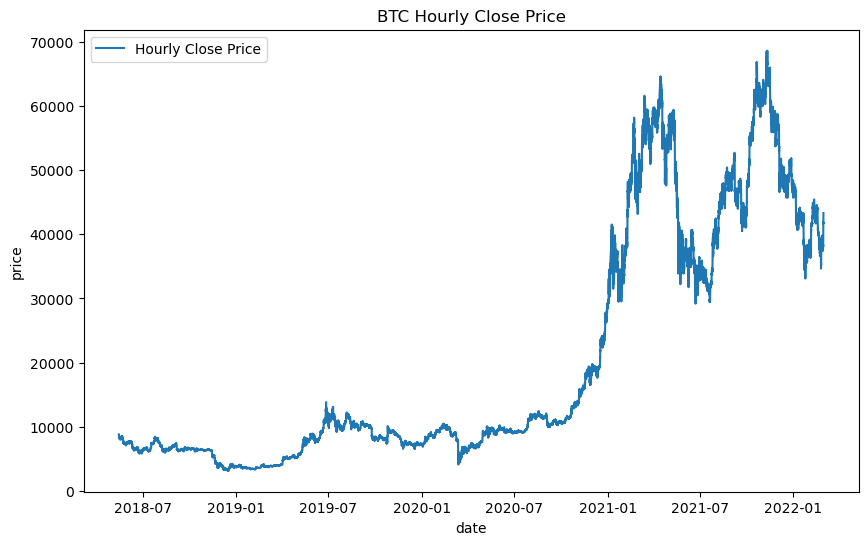

In [51]:
# Plot the hourly close price
plt.figure(figsize=(10,6))
plt.plot(btc_hourly.index, btc_hourly['close'], label='Hourly Close Price')
plt.title('BTC Hourly Close Price')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()

In [52]:
# Create additional time features for the XGBoost model
btc_hourly['hour'] = btc_hourly.index.hour
btc_hourly['dayofweek'] = btc_hourly.index.dayofweek
btc_hourly['month'] = btc_hourly.index.month

# Create lag features (using the previous 1 to 24 hours of the closing price)
for lag in range(1, 25):
    btc_hourly[f'lag_{lag}'] = btc_hourly['close'].shift(lag)

# Drop rows with missing values created by lagging
btc_hourly.dropna(inplace=True)

# Create the target variable as the next hour's closing price
btc_hourly['target'] = btc_hourly['close'].shift(-1)
btc_hourly.dropna(inplace=True)

# Define features and target for the model
feature_cols = [col for col in btc_hourly.columns if col.startswith('lag_')] + ['hour', 'dayofweek', 'month']
X = btc_hourly[feature_cols]
y = btc_hourly['target']

# Split the data into training and testing sets (maintaining time order)
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [53]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print("XGBoost Regressor Mean Squared Error:", mse)

XGBoost Regressor Mean Squared Error: 974965.7475554431


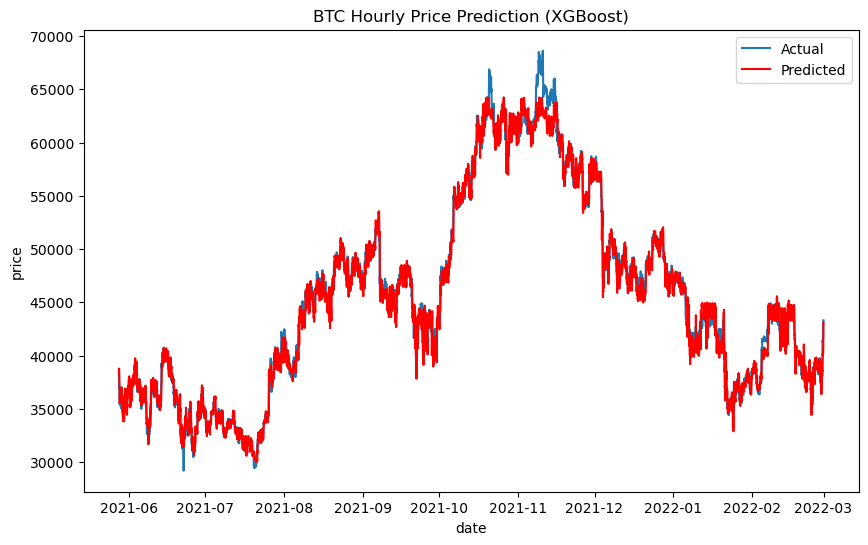

In [54]:
# Plot actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('BTC Hourly Price Prediction (XGBoost)')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()